## EDA


In [45]:
import pandas as pd

train = pd.read_csv("../data/raw/train.csv")
test  = pd.read_csv("../data/raw/test.csv")

print(train.shape)
train.head()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

(16209, 21)


In [47]:
train.info()
train.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [49]:
train["log_price"] = np.log1p(train["price"])


In [51]:
price_stats = {
    "mean_price": train["price"].mean(),
    "median_price": train["price"].median(),
    "min_price": train["price"].min(),
    "max_price": train["price"].max(),
    "std_price": train["price"].std()
}

pd.Series(price_stats)


mean_price      5.374703e+05
median_price    4.500000e+05
min_price       7.500000e+04
max_price       7.700000e+06
std_price       3.603036e+05
dtype: float64

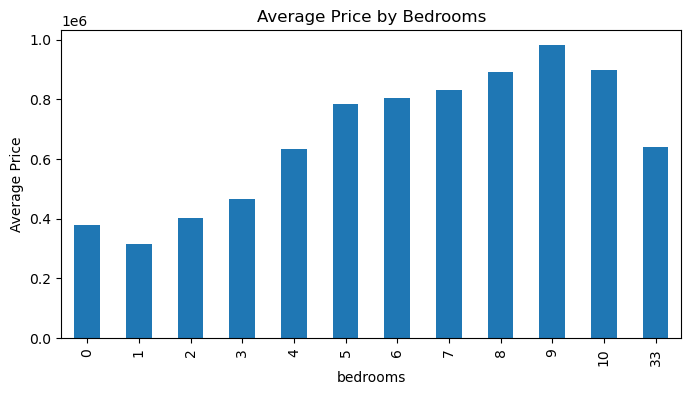

In [53]:
train.groupby("bedrooms")["price"].mean().plot(kind="bar", figsize=(8,4))
plt.title("Average Price by Bedrooms")
plt.ylabel("Average Price")
plt.show()


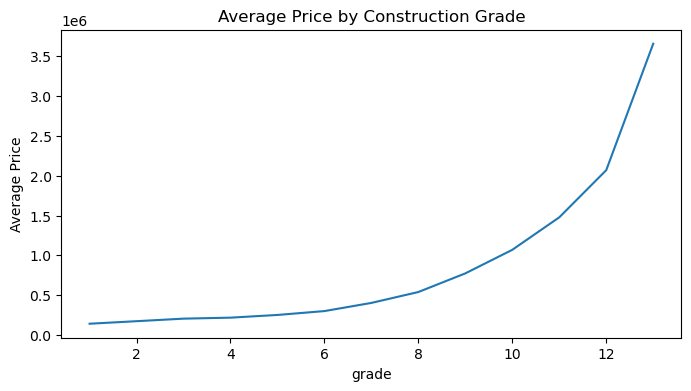

In [54]:
train.groupby("grade")["price"].mean().plot(figsize=(8,4))
plt.title("Average Price by Construction Grade")
plt.ylabel("Average Price")
plt.show()


In [56]:
train.groupby("waterfront")["price"].mean()


waterfront
0    5.300675e+05
1    1.591938e+06
Name: price, dtype: float64

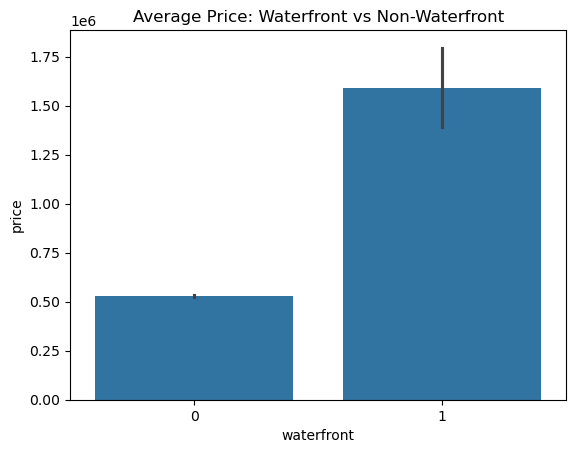

In [58]:
sns.barplot(x="waterfront", y="price", data=train)
plt.title("Average Price: Waterfront vs Non-Waterfront")
plt.show()


###  *Waterfront properties command a significant premium.

In [61]:
numeric_cols = train.select_dtypes(include=[np.number])

corr_with_price = (
    numeric_cols
    .corr()["log_price"]
    .sort_values(ascending=False)
)

corr_with_price


log_price        1.000000
price            0.893444
grade            0.700249
sqft_living      0.693377
sqft_living15    0.615312
sqft_above       0.596904
bathrooms        0.550492
lat              0.452503
view             0.340868
bedrooms         0.337664
sqft_basement    0.315438
floors           0.305348
waterfront       0.161167
yr_renovated     0.119410
sqft_lot         0.098102
sqft_lot15       0.086677
yr_built         0.076376
long             0.052900
condition        0.033024
id              -0.007350
zipcode         -0.039803
Name: log_price, dtype: float64

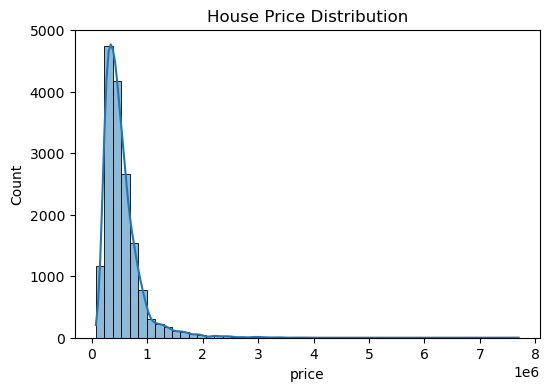

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(train["price"], bins=50, kde=True)
plt.title("House Price Distribution")
plt.show()


## House prices exhibit strong right skewness, motivating log transformation.

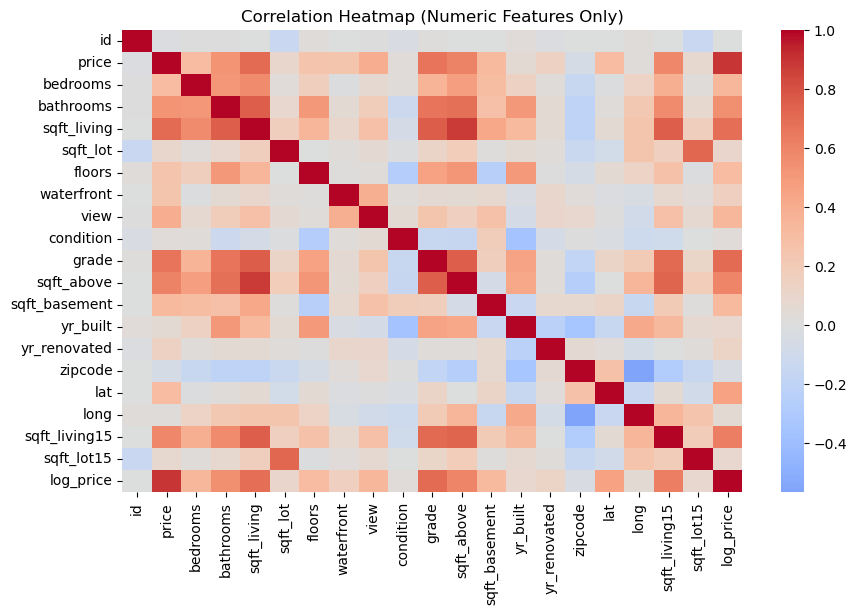

In [66]:
numeric_cols = train.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


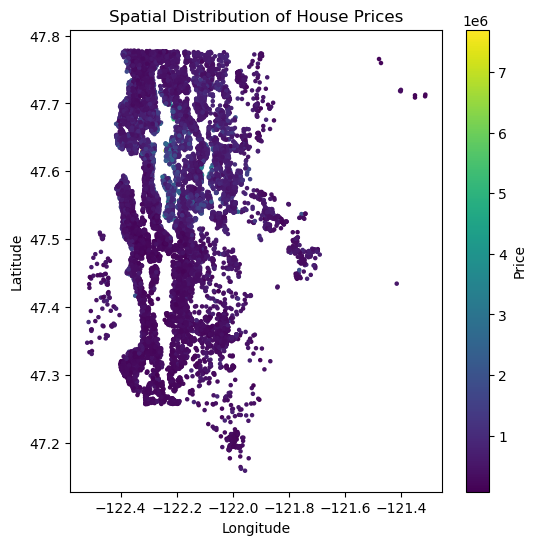

In [67]:
plt.figure(figsize=(6,6))
plt.scatter(
    train["long"],
    train["lat"],
    c=train["price"],
    cmap="viridis",
    s=5
)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of House Prices")
plt.show()


### *Prices cluster geographically, indicating strong neighborhood effects.

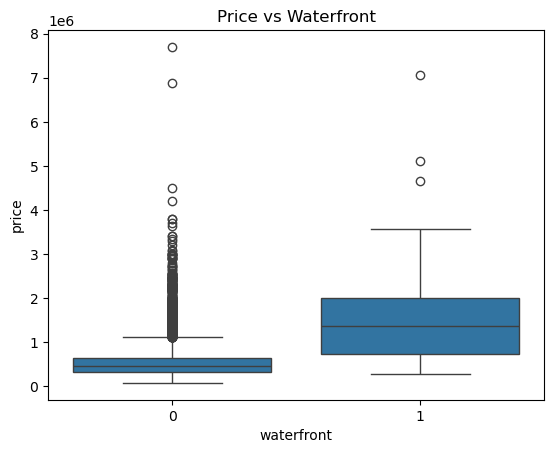

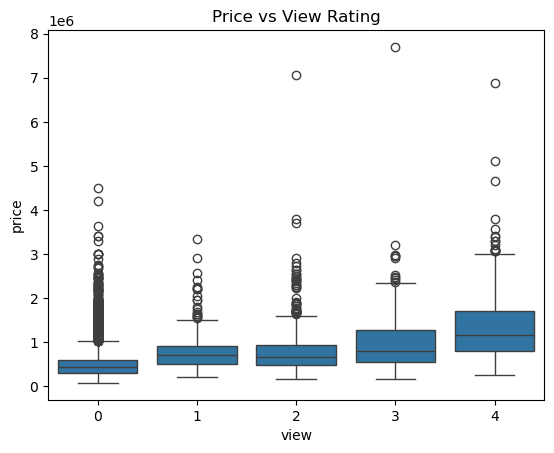

In [70]:
import seaborn as sns

sns.boxplot(x="waterfront", y="price", data=train)
plt.title("Price vs Waterfront")
plt.show()

sns.boxplot(x="view", y="price", data=train)
plt.title("Price vs View Rating")
plt.show()


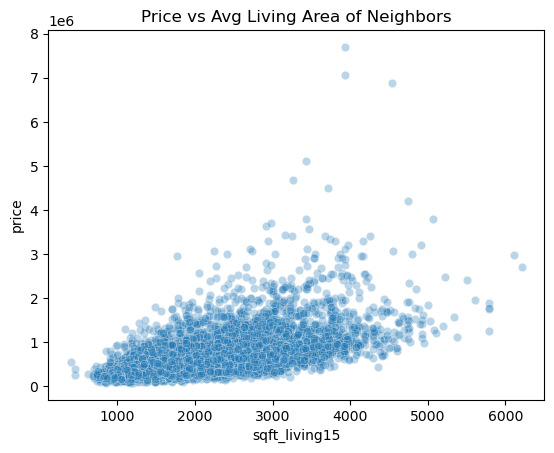

In [71]:
sns.scatterplot(
    x="sqft_living15",
    y="price",
    data=train,
    alpha=0.3
)
plt.title("Price vs Avg Living Area of Neighbors")
plt.show()


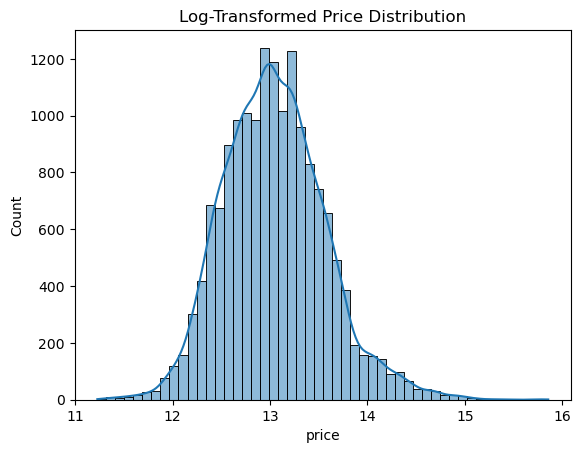

In [72]:
import numpy as np

sns.histplot(np.log1p(train["price"]), bins=50, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.show()


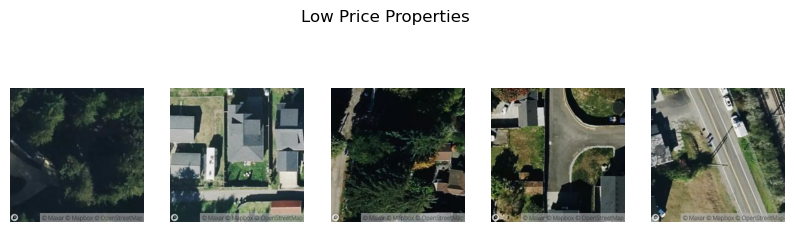

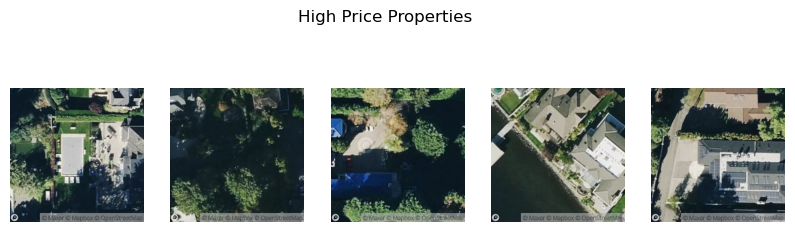

In [74]:
cheap_ids = train.sort_values("price").head(5)["id"]
exp_ids = train.sort_values("price", ascending=False).head(5)["id"]

from PIL import Image
import matplotlib.pyplot as plt

def show_images(ids, title):
    plt.figure(figsize=(10,3))
    for i, pid in enumerate(ids):
        img = Image.open(f"../data/images/train/{pid}.png")
        plt.subplot(1, len(ids), i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(cheap_ids, "Low Price Properties")
show_images(exp_ids, "High Price Properties")


In [80]:
train["log_price"] = np.log1p(train["price"])


In [82]:
def feature_engineering(df):
    df = df.copy()

    df["basement_ratio"] = df["sqft_basement"] / (df["sqft_living"] + 1)
    df["above_ratio"]    = df["sqft_above"] / (df["sqft_living"] + 1)

    df["relative_living_size"] = df["sqft_living"] / (df["sqft_living15"] + 1)
    df["relative_lot_size"]    = df["sqft_lot"] / (df["sqft_lot15"] + 1)

    df["luxury_grade"]   = (df["grade"] >= 9).astype(int)
    df["good_condition"] = (df["condition"] >= 4).astype(int)

    lat_center = df["lat"].mean()
    lon_center = df["long"].mean()

    df["dist_to_center"] = np.sqrt(
        (df["lat"] - lat_center) ** 2 +
        (df["long"] - lon_center) ** 2
    )

    df["lat_long_interaction"] = df["lat"] * df["long"]

    return df


In [84]:
train_fe = feature_engineering(train)


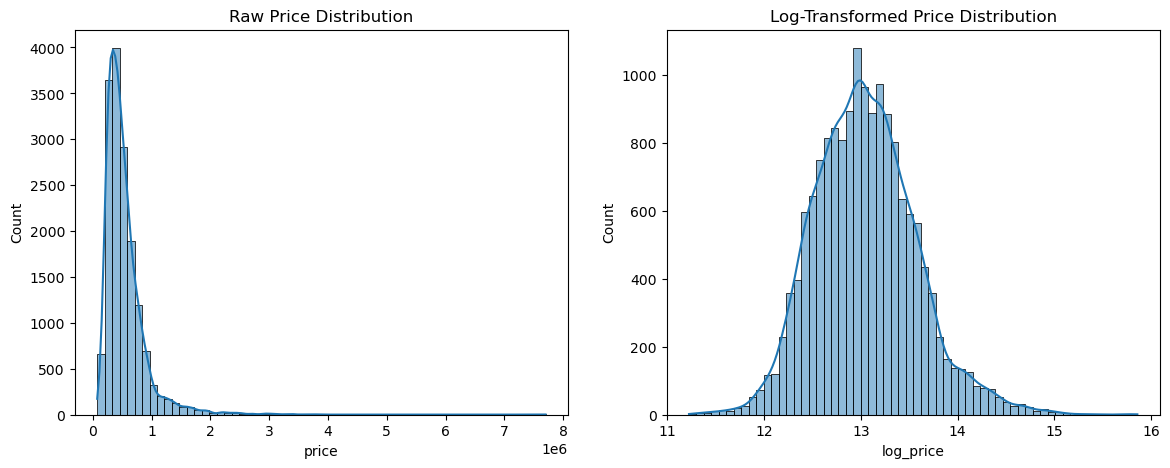

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(train["price"], bins=60, kde=True, ax=axes[0])
axes[0].set_title("Raw Price Distribution")

sns.histplot(train["log_price"], bins=60, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Price Distribution")

plt.show()


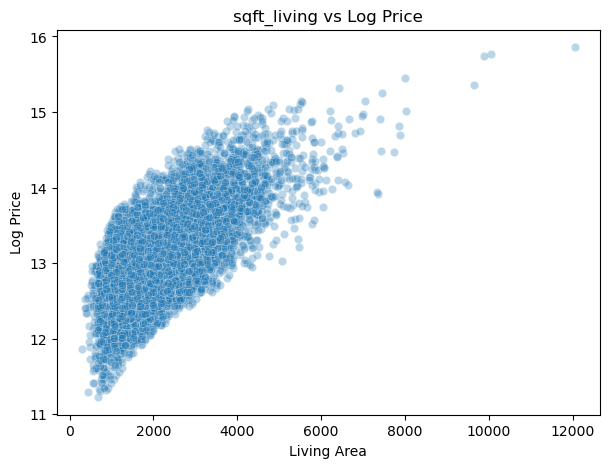

In [87]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train["sqft_living"],
    y=train["log_price"],
    alpha=0.3
)
plt.title("sqft_living vs Log Price")
plt.xlabel("Living Area")
plt.ylabel("Log Price")
plt.show()


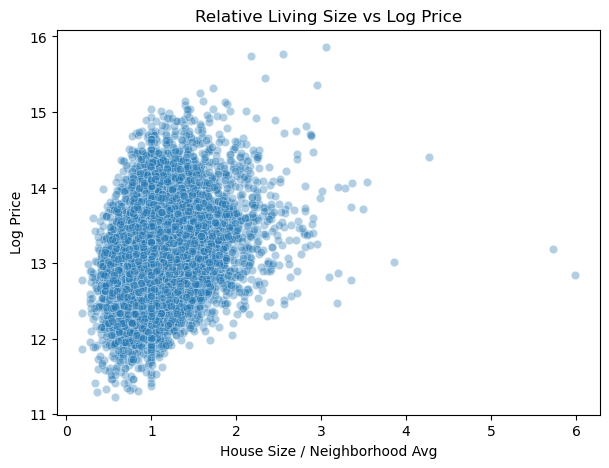

In [88]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train_fe["relative_living_size"],
    y=train["log_price"],
    alpha=0.35
)
plt.title("Relative Living Size vs Log Price")
plt.xlabel("House Size / Neighborhood Avg")
plt.ylabel("Log Price")
plt.show()


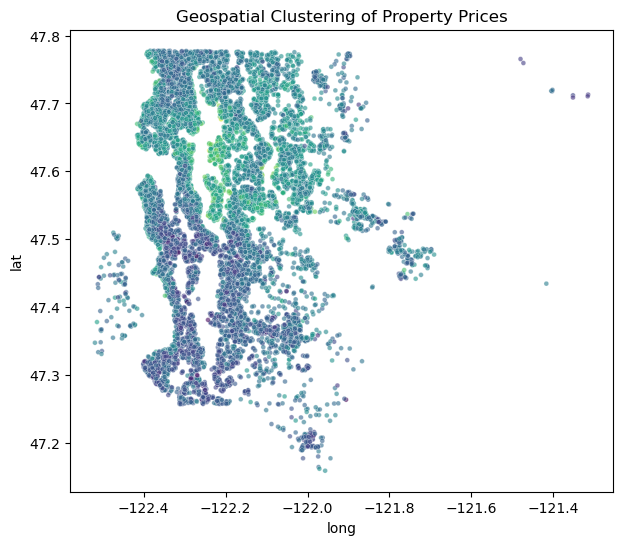

In [90]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x="long",
    y="lat",
    hue=train["log_price"],
    palette="viridis",
    data=train,
    s=12,
    alpha=0.6,
    legend=False
)
plt.title("Geospatial Clustering of Property Prices")
plt.show()


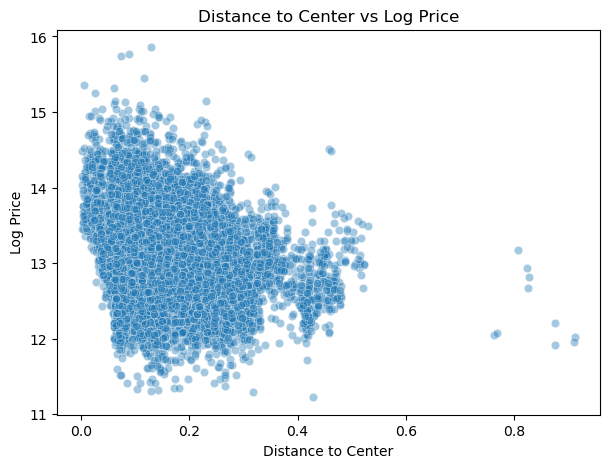

In [91]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train_fe["dist_to_center"],
    y=train["log_price"],
    alpha=0.4
)
plt.title("Distance to Center vs Log Price")
plt.xlabel("Distance to Center")
plt.ylabel("Log Price")
plt.show()


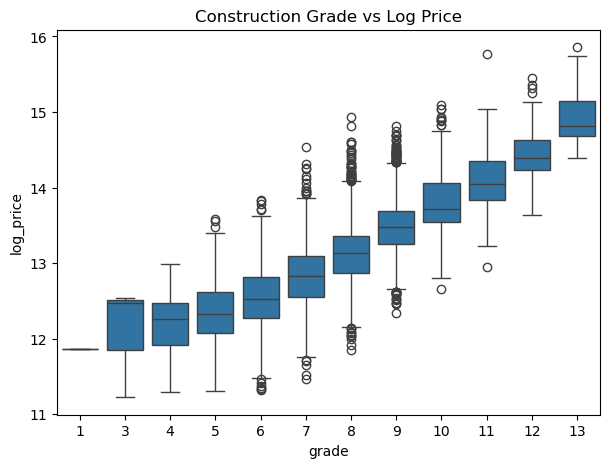

In [93]:
plt.figure(figsize=(7,5))
sns.boxplot(x=train["grade"], y=train["log_price"])
plt.title("Construction Grade vs Log Price")
plt.show()


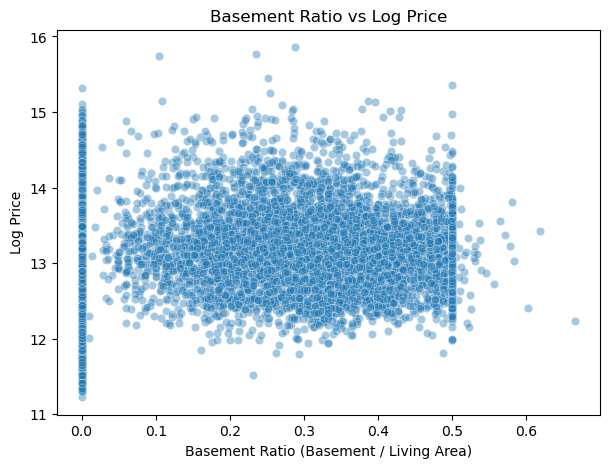

In [94]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train_fe["basement_ratio"],
    y=train["log_price"],
    alpha=0.4
)
plt.title("Basement Ratio vs Log Price")
plt.xlabel("Basement Ratio (Basement / Living Area)")
plt.ylabel("Log Price")
plt.show()


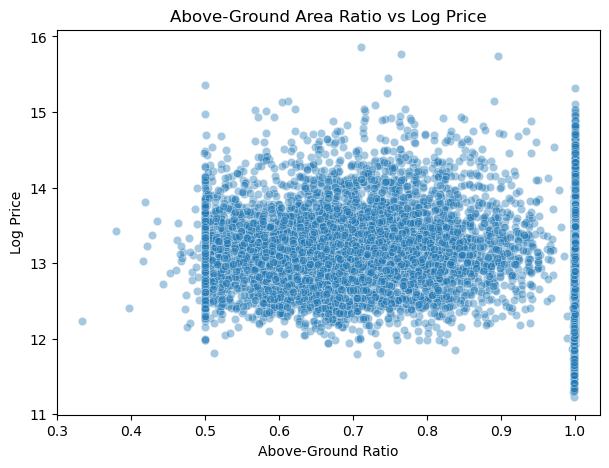

In [100]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train_fe["above_ratio"],
    y=train["log_price"],
    alpha=0.4
)
plt.title("Above-Ground Area Ratio vs Log Price")
plt.xlabel("Above-Ground Ratio")
plt.ylabel("Log Price")
plt.show()


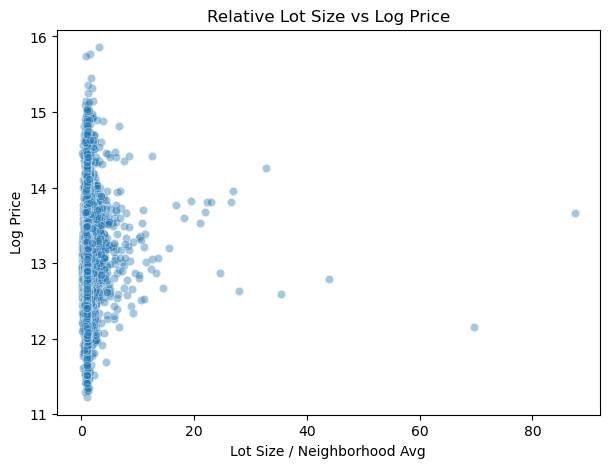

In [104]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=train_fe["relative_lot_size"],
    y=train["log_price"],
    alpha=0.4
)
plt.title("Relative Lot Size vs Log Price")
plt.xlabel("Lot Size / Neighborhood Avg")
plt.ylabel("Log Price")
plt.show()


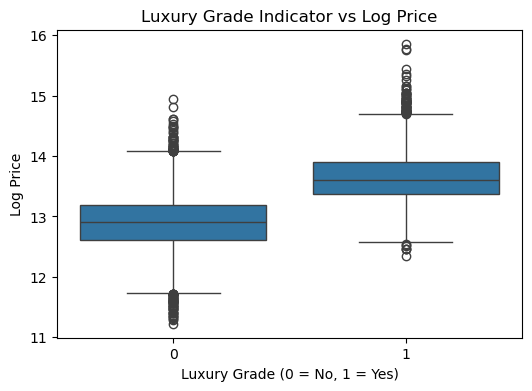

In [106]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x=train_fe["luxury_grade"],
    y=train["log_price"]
)
plt.title("Luxury Grade Indicator vs Log Price")
plt.xlabel("Luxury Grade (0 = No, 1 = Yes)")
plt.ylabel("Log Price")
plt.show()


In [110]:
engineered_cols = [
    "basement_ratio",
    "above_ratio",
    "relative_living_size",
    "relative_lot_size",
    "luxury_grade",
    "good_condition",
    "dist_to_center",
    "lat_long_interaction"
]

corr_engineered = (
    train_fe[engineered_cols]
    .assign(log_price=train["log_price"])
    .corr()["log_price"]
    .sort_values(ascending=False)
)

corr_engineered


log_price               1.000000
luxury_grade            0.573219
relative_living_size    0.300085
basement_ratio          0.176139
relative_lot_size       0.036742
good_condition         -0.006487
above_ratio            -0.175311
dist_to_center         -0.251915
lat_long_interaction   -0.383614
Name: log_price, dtype: float64

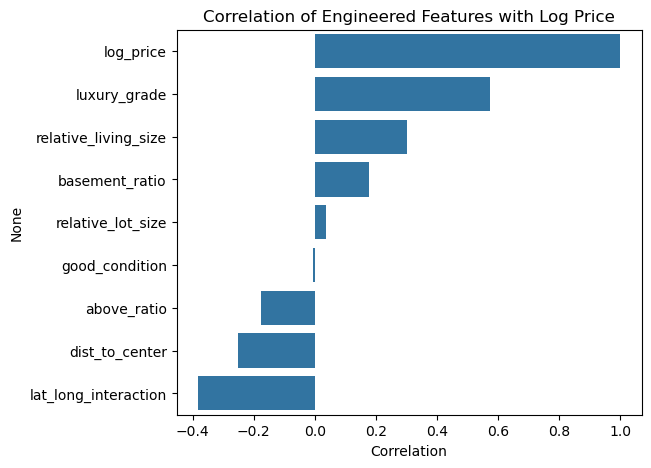

In [112]:
plt.figure(figsize=(6,5))
sns.barplot(
    x=corr_engineered.values,
    y=corr_engineered.index
)
plt.title("Correlation of Engineered Features with Log Price")
plt.xlabel("Correlation")
plt.show()
